# Predicting California housing prices using ensemble learning

In this notebook we will use a Random Forest model to predict housing prices of houses in California.


# 📦 Data provisioning

The California housing dataset can be loaded using scikit-learn:

In [1]:
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()

# Inspect the dataset

Let's first have a look into the format of the dataset.

In [2]:
dataset

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

We can see that there are 8 features (mentioned under feature names) and one continuous target variable MedHouseVal (median house value).

# 📃 Sample the data

In [3]:
X = dataset.data
y = dataset.target

In [4]:
X[0:10]


array([4.526, 3.585, 3.521, 3.413, 3.422, 2.697, 2.992, 2.414, 2.267,
       2.611])

In [5]:
y[0:10]

array([4.526, 3.585, 3.521, 3.413, 3.422, 2.697, 2.992, 2.414, 2.267,
       2.611])

# 🛠️ Preprocessing
Since all features are already clean, we don't need to do any preprocessing in this case. Do take into account that longitude and latitude are related and mean something in real life (the location of the house). One could argue that these two features mean something in real life and we should treat them differently. However, since this is not the focus of this notebook we will treat them as separate features.

## 🪓 Splitting into train/test

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=21
)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 20640 observations, of which 15480 are now in the train set, and 5160 in the test set.


## 🧬 Modelling

### Decision Tree

Let's start by applying a Decision Tree as we have seen before. Since our target variable is continuous, we do not have a classification problem but a regression problem. This means we will have to use the DecisionTreeRegressor from sklearn.

In [7]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=21, max_depth=25)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.6008678894603974

The R-squared value is about 0.6. Although this shows that our model can predict something, it is not exactly mind-blowing.

This is not the end of the story though. Let's try doing the same with max_depth=10.

In [8]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=21, max_depth=10)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.6885848151723583

The R-squared just went up almost by 0.09! How would you explain this?

The next question is what would be the best value for the parameter max_depth. In the exercise we will find this by applying grid search.

## Random Forest

Now let's see whether we can improve our model by applying a Random Forest. This is an example of a bagging ensemble algorithm, since we construct trees based on different (random) samples of the input data.

In [9]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators = 50, max_depth=25, n_jobs=-1)
random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.8050417860881305

There is some randomness in the model, so we find different accuracies every time we run it. We tend to find R-squared values of around 0.8 which is quite an improvement with using a single decision tree! Let's see whether we can do better by optimizing the n_estimators parameter.

In [10]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators = 100, max_depth=25, n_jobs=-1)
random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.8093268104631148

Our result got a little bit better, but we would have to validate this using cross-validation to make proper conclusions. We will do so in the exercise, while finding a good value for the parameter n_estimators.

## Feature importance

An important benefit of using random forests is that we can get some idea what features were important when determining the target variables (median house price).

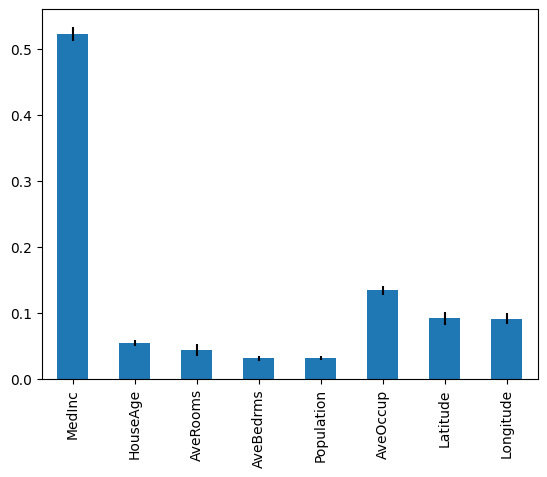

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

forest_importances = pd.Series(random_forest.feature_importances_, index=dataset.feature_names)

standard_deviation = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

plt.figure()
forest_importances.plot.bar(yerr=standard_deviation)
plt.show()

We observe that the MedInc (median income) seems to be the most important variable in predicting the median house price. The second most important feature is AveOccup (average occupation), then the latitude and longitude. Does this match your expectations?

In [12]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR



# Now you can use these boosted estimators in your ensemble
estimators = [ 
    ('ridge', RidgeCV()),  
    ('svr', LinearSVR(dual="auto", random_state=21)), 
    ('dtr', DecisionTreeRegressor(random_state=21, max_depth=15))
]

reg = StackingRegressor( estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=10, random_state=21, max_depth=12) )

reg.fit(X_train, y_train).score(X_test, y_test)

C:\Users\Anne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Anne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Anne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Anne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear fail

0.7814795740178104

In [13]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import AdaBoostRegressor


# Define base estimators
ridge = RidgeCV()
svr = LinearSVR(dual="auto", random_state=21)
dtr = DecisionTreeRegressor(random_state=21, max_depth=15)

# Apply AdaBoost to each base estimator
ridge_boosted = AdaBoostRegressor(estimator=ridge, random_state=0, n_estimators=100)
svr_boosted = AdaBoostRegressor(estimator=svr, random_state=0, n_estimators=100)
dtr_boosted = AdaBoostRegressor(estimator=dtr, random_state=0, n_estimators=100)

# Now you can use these boosted estimators in your ensemble
estimators = [ 
    ('ridge_boosted', ridge_boosted),  
    ('svr_boosted', svr_boosted), 
    ('dtr_boosted', dtr_boosted)
]

reg = StackingRegressor( estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=10, random_state=21, max_depth=12) )

reg.fit(X_train, y_train).score(X_test, y_test)

C:\Users\Anne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Anne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Anne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Anne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear fail

0.8113846777187396

In [14]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

parameters = {'random_state':list(range(4, 51)), 'max_depth':list(range(5, 51))}

dtr = DecisionTreeRegressor()
clf = GridSearchCV(dtr, parameters, n_jobs=-1)
clf.fit(X_train, y_train)

df = pd.DataFrame(clf.cv_results_)
df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
239,0.143508,0.011802,0.001084,0.001467,10,8,"{'max_depth': 10, 'random_state': 8}",0.655621,0.691029,0.685845,0.673280,0.700821,0.681319,0.015621,1
251,0.157496,0.017068,0.001498,0.002751,10,20,"{'max_depth': 10, 'random_state': 20}",0.654652,0.680625,0.683388,0.676777,0.702934,0.679675,0.015429,2
164,0.117253,0.004696,0.001952,0.001858,8,27,"{'max_depth': 8, 'random_state': 27}",0.681218,0.693028,0.663992,0.671748,0.688248,0.679647,0.010611,3
184,0.118346,0.004283,0.001450,0.001776,8,47,"{'max_depth': 8, 'random_state': 47}",0.680727,0.694025,0.664318,0.667236,0.690217,0.679305,0.011900,4
245,0.137959,0.003827,0.002007,0.004014,10,14,"{'max_depth': 10, 'random_state': 14}",0.655579,0.685318,0.681351,0.677908,0.695495,0.679130,0.013170,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,0.252296,0.021998,0.002924,0.003036,26,46,"{'max_depth': 26, 'random_state': 46}",0.560923,0.572897,0.590023,0.594332,0.596673,0.582970,0.013814,2158
1183,0.252808,0.018893,0.001971,0.001040,30,12,"{'max_depth': 30, 'random_state': 12}",0.556692,0.566323,0.585792,0.589961,0.614473,0.582648,0.020082,2159
1072,0.262373,0.016475,0.004110,0.003016,27,42,"{'max_depth': 27, 'random_state': 42}",0.548495,0.581016,0.584821,0.585439,0.611149,0.582184,0.019964,2160
1020,0.240246,0.004891,0.001621,0.001006,26,37,"{'max_depth': 26, 'random_state': 37}",0.559927,0.564383,0.591397,0.585016,0.609216,0.581988,0.018087,2161


In [16]:
parameters = {'bootstrap':[True, False], 'random_state':list(range(20, 51)), 'n_jobs':[-1]}

dtr = BaggingRegressor()
clf = GridSearchCV(dtr, parameters)
clf.fit(X_train, y_train)

df = pd.DataFrame(clf.cv_results_)
df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_n_jobs,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.168148,0.019381,0.026524,0.004920,True,-1,34,"{'bootstrap': True, 'n_jobs': -1, 'random_stat...",0.788279,0.782279,0.766094,0.775729,0.794858,0.781448,0.009956,1
17,0.167585,0.003541,0.028639,0.005333,True,-1,37,"{'bootstrap': True, 'n_jobs': -1, 'random_stat...",0.783456,0.772154,0.782001,0.775796,0.792305,0.781142,0.006929,2
19,0.165366,0.006486,0.024383,0.004326,True,-1,39,"{'bootstrap': True, 'n_jobs': -1, 'random_stat...",0.785870,0.780831,0.772264,0.777190,0.785631,0.780357,0.005176,3
30,0.158126,0.006887,0.024138,0.004255,True,-1,50,"{'bootstrap': True, 'n_jobs': -1, 'random_stat...",0.789085,0.775420,0.773077,0.772015,0.791815,0.780283,0.008419,4
22,0.158998,0.009240,0.023603,0.004197,True,-1,42,"{'bootstrap': True, 'n_jobs': -1, 'random_stat...",0.785337,0.776581,0.772954,0.768331,0.796241,0.779889,0.009897,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.242168,0.011619,0.145684,0.001267,False,-1,49,"{'bootstrap': False, 'n_jobs': -1, 'random_sta...",0.590925,0.600492,0.616969,0.624127,0.637991,0.614101,0.016744,58
48,0.248534,0.013308,0.144690,0.001020,False,-1,37,"{'bootstrap': False, 'n_jobs': -1, 'random_sta...",0.590028,0.599280,0.619804,0.621742,0.638388,0.613848,0.017203,59
53,0.254132,0.009830,0.148759,0.004636,False,-1,42,"{'bootstrap': False, 'n_jobs': -1, 'random_sta...",0.589390,0.598321,0.622245,0.623778,0.634931,0.613733,0.017046,60
34,0.252508,0.004007,0.149753,0.005934,False,-1,23,"{'bootstrap': False, 'n_jobs': -1, 'random_sta...",0.592059,0.598467,0.615734,0.619774,0.641040,0.613415,0.017254,61


and here i use baggingregression to see what that does. and it isn't better or worse than the rest so. don't know how it will work in other datasets though

In [17]:
model = BaggingRegressor()

model.fit(X_train, y_train).score(X_test, y_test)

0.7953496000281135